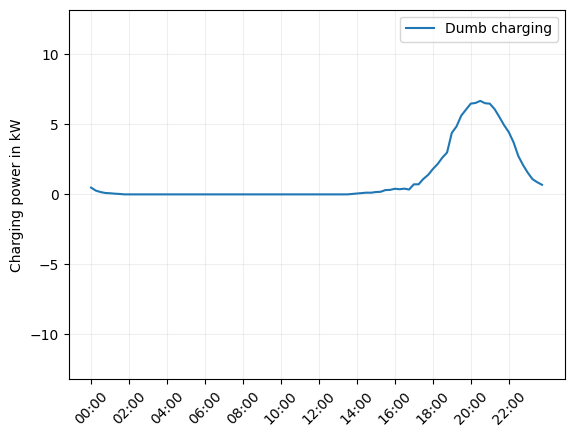

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from FleetRL.fleet_env.fleet_environment import FleetEnv

if __name__ == "__main__":

    # define parameters here for easier change
    n_steps = 8600
    n_episodes = 1
    n_evs = 1
    n_envs = 1
    timesteps_per_hour = 4
    use_case: str = "lmd"  # for file name

    dumb_vec_env = make_vec_env(FleetEnv,
                                    n_envs=n_envs,
                                    vec_env_cls=SubprocVecEnv,
                                    env_kwargs={
                                        "schedule_name": "lmd_sched_single_eval.csv",
                                        "building_name": "load_lmd.csv",
                                        "price_name": "spot_2021_new.csv",
                                        "tariff_name": "spot_2021_new_tariff.csv",
                                        "use_case": "lmd",
                                        "include_building": True,
                                        "include_pv": True,
                                        "time_picker": "static",
                                        "deg_emp": False,
                                        "include_price": True,
                                        "ignore_price_reward": False,
                                        "ignore_invalid_penalty": True,
                                        "ignore_overcharging_penalty": True,
                                        "ignore_overloading_penalty": False,
                                        "episode_length": n_steps,
                                        "normalize_in_env": False,
                                        "verbose": 0,
                                        "aux": True,
                                        "log_data": True,
                                        "calculate_degradation": True,
                                        "spot_markup": 10,
                                        "spot_mul": 1.5,
                                        "feed_in_ded": 0.25
                                    })
    # %%
    dumb_norm_vec_env = VecNormalize(venv=dumb_vec_env,
                                     norm_obs=True,
                                     norm_reward=True,
                                     training=True,
                                     clip_reward=10.0)

    episode_length = n_steps
    n_episodes = n_episodes
    dumb_norm_vec_env.reset()

    for i in range(episode_length * timesteps_per_hour * n_episodes):
        if dumb_norm_vec_env.env_method("is_done")[0]:
            dumb_norm_vec_env.reset()
        dumb_norm_vec_env.step([np.ones(n_evs)])

    dumb_log: pd.DataFrame = dumb_norm_vec_env.env_method("get_log")[0]

    dumb_log.reset_index(drop=True, inplace=True)
    dumb_log = dumb_log.iloc[0:-2]

    dumb_log.to_csv(f"log_dumb_{use_case}_{n_evs}.csv")

    real_power_dumb = []
    for i in range(dumb_log.__len__()):
        dumb_log.loc[i, "hour_id"] = (dumb_log.loc[i, "Time"].hour + dumb_log.loc[i, "Time"].minute / 60)

    mean_per_hid_dumb = dumb_log.groupby("hour_id").mean()["Charging energy"].reset_index(drop=True)
    mean_all_dumb = []
    for i in range(mean_per_hid_dumb.__len__()):
        mean_all_dumb.append(np.mean(mean_per_hid_dumb[i]))

    mean_dumb = pd.DataFrame()
    mean_dumb["Dumb charging"] = np.multiply(mean_all_dumb, 4)

    mean_dumb.plot()

    plt.xticks([0,8,16,24,32,40,48,56,64,72,80,88]
               ,["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00"],
               rotation=45)

    plt.legend()
    plt.grid(alpha=0.2)

    plt.ylabel("Charging power in kW")
    max = dumb_log.loc[0, "Observation"][-10]
    plt.ylim([-max * 1.2, max * 1.2])

    plt.show()

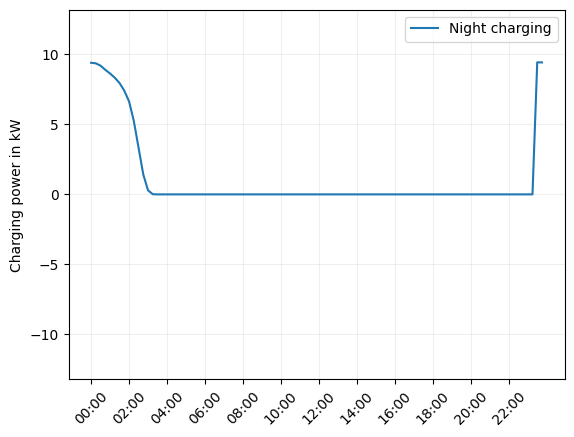

In [2]:
from copy import copy

import pandas as pd
import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

from FleetRL.fleet_env.fleet_environment import FleetEnv

if __name__ == "__main__":


    # define parameters here for easier change
    n_steps = 8600
    n_episodes = 1
    n_evs = 1
    n_envs = 1
    timesteps_per_hour = 4
    use_case: str = "lmd"  # for file name

    env_kwargs= {"schedule_name": "lmd_sched_single_eval.csv",
                "building_name": "load_lmd.csv",
                "price_name": "spot_2021_new.csv",
                "tariff_name": "spot_2021_new_tariff.csv",
                "use_case": "lmd",
                "include_building": True,
                "include_pv": True,
                "time_picker": "static",
                "deg_emp": False,
                "include_price": True,
                "ignore_price_reward": False,
                "ignore_invalid_penalty": True,
                "ignore_overcharging_penalty": True,
                "ignore_overloading_penalty": False,
                "episode_length": n_steps,
                "normalize_in_env": False,
                "verbose": 0,
                "aux": True,
                "log_data": True,
                "calculate_degradation": True,
                "spot_markup": 10,
                "spot_mul": 1.5,
                "feed_in_ded": 0.25
                }

    night_vec_env = make_vec_env(FleetEnv,
                                n_envs=n_envs,
                                vec_env_cls=SubprocVecEnv,
                                env_kwargs=env_kwargs)

    night_norm_vec_env = VecNormalize(venv=night_vec_env,
                                     norm_obs=True,
                                     norm_reward=True,
                                     training=True,
                                     clip_reward=10.0)

    env = FleetEnv(use_case=use_case,
                   schedule_name=env_kwargs["schedule_name"],
                   tariff_name=env_kwargs["tariff_name"],
                   price_name=env_kwargs["price_name"],
                   episode_length=n_steps,
                   time_picker=env_kwargs["time_picker"],
                   building_name=env_kwargs["building_name"])

    df = env.db
    df_leaving_home = df[(df['Location'].shift() == 'home') & (df['Location'] == 'driving')]
    earliest_dep_time = df_leaving_home['date'].dt.time.min()
    day_of_earliest_dep = df_leaving_home[df_leaving_home['date'].dt.time == earliest_dep_time]['date'].min()
    earliest_dep = earliest_dep_time.hour + earliest_dep_time.minute/60

    evse = env.load_calculation.evse_max_power
    cap = env.ev_conf.init_battery_cap
    target_soc = env.ev_conf.target_soc
    eff = env.ev_conf.charging_eff

    max_time_needed = target_soc * cap / eff / evse  # time needed to charge to target soc from 0
    difference = earliest_dep - max_time_needed
    starting_time = (24 + difference)
    if starting_time > 24:
        starting_time = 23.99 # always start just before midnight

    charging_hour = int(math.modf(starting_time)[1])
    minutes = np.asarray([0, 15, 30, 45])
    # split number and decimals, use decimals and choose the closest minute
    closest_index = np.abs(minutes - int(math.modf(starting_time)[0]*60)).argmin()
    charging_minute = minutes[closest_index]

    episode_length = n_steps
    n_episodes = n_episodes
    night_norm_vec_env.reset()

    charging=False

    for i in range(episode_length * timesteps_per_hour * n_episodes):
        if night_norm_vec_env.env_method("is_done")[0]:
            night_norm_vec_env.reset()
        time: pd.Timestamp = night_norm_vec_env.env_method("get_time")[0]
        if (((charging_hour <= time.hour) and (charging_minute <= time.minute)) or (charging)):
            if not charging:
                charging_start: pd.Timestamp = copy(time)
            charging=True
            night_norm_vec_env.step([np.ones(n_evs)])
        else:
            night_norm_vec_env.step([np.zeros(n_evs)])
        if charging and ((time - charging_start).total_seconds()/3600 > int(max_time_needed)):
            charging = False

    night_log: pd.DataFrame = night_norm_vec_env.env_method("get_log")[0]

    night_log.reset_index(drop=True, inplace=True)
    night_log = night_log.iloc[0:-2]

    night_log.to_csv(f"log_night_{use_case}_{n_evs}.csv")
    real_power_night = []
    for i in range(night_log.__len__()):
        night_log.loc[i, "hour_id"] = (night_log.loc[i, "Time"].hour + night_log.loc[i, "Time"].minute / 60)

    mean_per_hid_night = night_log.groupby("hour_id").mean()["Charging energy"].reset_index(drop=True)
    mean_all_night = []
    for i in range(mean_per_hid_night.__len__()):
        mean_all_night.append(np.mean(mean_per_hid_night[i]))

    mean_night = pd.DataFrame()
    mean_night["Night charging"] = np.multiply(mean_all_night, 4)

    mean_night.plot()

    plt.xticks([0,8,16,24,32,40,48,56,64,72,80,88]
               ,["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00"],
               rotation=45)

    plt.legend()
    plt.grid(alpha=0.2)

    plt.ylabel("Charging power in kW")
    max = night_log.loc[0, "Observation"][-10]
    plt.ylim([-max * 1.2, max * 1.2])

    plt.show()



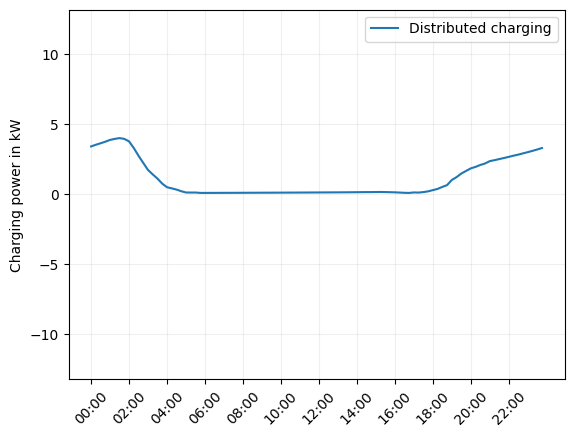

In [38]:

import pandas as pd
import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

from FleetRL.fleet_env.fleet_environment import FleetEnv

if __name__ == "__main__":


    # define parameters here for easier change
    n_steps = 8600
    n_episodes = 1
    n_evs = 1
    n_envs = 1
    timesteps_per_hour = 4
    use_case: str = "lmd"  # for file name

    env_kwargs= {"schedule_name": "lmd_sched_single_eval.csv",
                "building_name": "load_lmd.csv",
                "price_name": "spot_2021_new.csv",
                "tariff_name": "spot_2021_new_tariff.csv",
                "use_case": "lmd",
                "include_building": True,
                "include_pv": True,
                "time_picker": "static",
                "deg_emp": False,
                "include_price": True,
                "ignore_price_reward": False,
                "ignore_invalid_penalty": True,
                "ignore_overcharging_penalty": True,
                "ignore_overloading_penalty": False,
                "episode_length": n_steps,
                "normalize_in_env": False,
                "verbose": 0,
                "aux": True,
                "log_data": True,
                "calculate_degradation": True,
                "spot_markup": 10,
                "spot_mul": 1.5,
                "feed_in_ded": 0.25
                }

    dist_vec_env = make_vec_env(FleetEnv,
                                n_envs=n_envs,
                                vec_env_cls=SubprocVecEnv,
                                env_kwargs=env_kwargs)

    dist_norm_vec_env = VecNormalize(venv=dist_vec_env,
                                     norm_obs=True,
                                     norm_reward=True,
                                     training=True,
                                     clip_reward=10.0)

    env = FleetEnv(use_case=use_case,
                   schedule_name=env_kwargs["schedule_name"],
                   tariff_name=env_kwargs["tariff_name"],
                   price_name=env_kwargs["price_name"],
                   episode_length=n_steps,
                   time_picker=env_kwargs["time_picker"],
                   building_name=env_kwargs["building_name"])

    episode_length = n_steps
    n_episodes = n_episodes
    dist_norm_vec_env.reset()

    for i in range(episode_length * timesteps_per_hour * n_episodes):
        if dist_norm_vec_env.env_method("is_done")[0]:
            dist_norm_vec_env.reset()
        dist_norm_vec_env.step(([np.clip(np.multiply(np.ones(n_evs), dist_norm_vec_env.env_method("get_dist_factor")[0]),0,1)]))


    dist_log: pd.DataFrame = dist_norm_vec_env.env_method("get_log")[0]

    dist_log.reset_index(drop=True, inplace=True)
    dist_log = dist_log.iloc[0:-2]

    dist_log.to_csv(f"log_dist_{use_case}_{n_evs}.csv")
    real_power_dist = []
    for i in range(dist_log.__len__()):
        dist_log.loc[i, "hour_id"] = (dist_log.loc[i, "Time"].hour + dist_log.loc[i, "Time"].minute / 60)

    mean_per_hid_dist = dist_log.groupby("hour_id").mean()["Charging energy"].reset_index(drop=True)
    mean_all_dist = []
    for i in range(mean_per_hid_dist.__len__()):
        mean_all_dist.append(np.mean(mean_per_hid_dist[i]))

    mean_dist = pd.DataFrame()
    mean_dist["Distributed charging"] = np.multiply(mean_all_dist, 4)

    mean_dist.plot()

    plt.xticks([0,8,16,24,32,40,48,56,64,72,80,88]
               ,["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00"],
               rotation=45)

    plt.legend()
    plt.grid(alpha=0.2)

    plt.ylabel("Charging power in kW")
    max = dist_log.loc[0, "Observation"][-10]
    plt.ylim([-max * 1.2, max * 1.2])

    plt.show()



In [37]:
dist_log["SOC violation"].max()

0.0

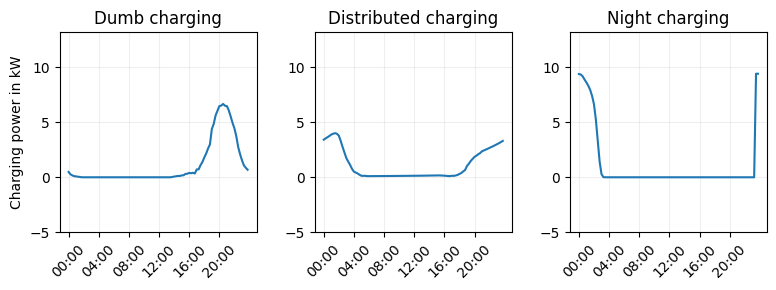

In [39]:
import matplotlib.pyplot as plt

# Create a 1x3 subplot grid
fig, axs = plt.subplots(1, 3, figsize=(8, 3))  # Adjust figsize as needed

# First subplot
mean_dumb.plot(ax=axs[0], legend=False)
axs[0].set_xticks([0,16,32,48,64,80])
axs[0].set_xticklabels(["00:00","04:00","08:00","12:00","16:00","20:00"], rotation=45)
axs[0].grid(alpha=0.2)
axs[0].set_ylabel("Charging power in kW")
max_val = dist_log.loc[0, "Observation"][-10]
axs[0].set_ylim([-5, max_val * 1.2])
axs[0].set_title("Dumb charging")

# Second subplot
mean_dist.plot(ax=axs[1], legend=False)
axs[1].set_xticks([0,16,32,48,64,80])
axs[1].set_xticklabels(["00:00","04:00","08:00","12:00","16:00","20:00"], rotation=45)
axs[1].grid(alpha=0.2)
axs[1].set_ylim([-5, max_val * 1.2])
axs[1].set_title("Distributed charging")


# Third subplot
mean_night.plot(ax=axs[2], legend=False)
axs[2].set_xticks([0,16,32,48,64,80])
axs[2].set_xticklabels(["00:00","04:00","08:00","12:00","16:00","20:00"], rotation=45)
axs[2].grid(alpha=0.2)
axs[2].set_ylim([-5, max_val * 1.2])
axs[2].set_title("Night charging")

plt.tight_layout()
plt.savefig("static_benchmarks_lmd.pdf")
plt.show()


In [40]:
dist_log["SOC violation"].max()

0.0

In [ ]:
    rl_cashflow = log_RL["Cashflow"].sum()
    rl_reward = log_RL["Reward"].sum()
    rl_deg = log_RL["Degradation"].sum()
    rl_overloading = log_RL["Grid overloading"].sum()
    rl_soc_violation = log_RL["SOC violation"].sum()
    rl_n_violations = log_RL[log_RL["SOC violation"] > 0]["SOC violation"].size
    rl_soh = log_RL["SOH"].iloc[-1]

    dumb_cashflow = dumb_log["Cashflow"].sum()
    dumb_reward = dumb_log["Reward"].sum()
    dumb_deg = dumb_log["Degradation"].sum()
    dumb_overloading = dumb_log["Grid overloading"].sum()
    dumb_soc_violation = dumb_log["SOC violation"].sum()
    dumb_n_violations = dumb_log[dumb_log["SOC violation"] > 0]["SOC violation"].size
    dumb_soh = dumb_log["SOH"].iloc[-1]

    print(f"RL reward: {rl_reward}")
    print(f"DC reward: {dumb_reward}")
    print(f"RL cashflow: {rl_cashflow}")
    print(f"DC cashflow: {dumb_cashflow}")

    total_results = pd.DataFrame()
    total_results["Category"] = ["Reward", "Cashflow", "Average degradation per EV", "Overloading", "SOC violation", "# Violations", "SOH"]

    total_results["RL-based charging"] = [rl_reward,
                                          rl_cashflow,
                                          np.round(np.mean(rl_deg), 5),
                                          rl_overloading,
                                          rl_soc_violation,
                                          rl_n_violations,
                                          np.round(np.mean(rl_soh), 5)]

    total_results["Dumb charging"] = [dumb_reward,
                                      dumb_cashflow,
                                      np.round(np.mean(dumb_deg), 5),
                                      dumb_overloading,
                                      dumb_soc_violation,
                                      dumb_n_violations,
                                      np.round(np.mean(dumb_soh), 5)]

    print(total_results)

In [15]:
df = env.db
df_leaving_home = df[(df['Location'].shift() == 'home') & (df['Location'] == 'driving')]
earliest_dep_time = df_leaving_home['date'].dt.time.min()
day_of_earliest_dep = df_leaving_home[df_leaving_home['date'].dt.time == earliest_dep_time]['date'].min()
earliest_dep = earliest_dep_time.hour + earliest_dep_time.minute/60
earliest_dep

4.25

In [13]:
df = env.db
df_leaving_home = df[(df['Location'].shift() == 'driving') & (df['Location'] == 'home')]
latest_arr_time = df_leaving_home['date'].dt.time.max()
day_of_latest_arr = df_leaving_home[df_leaving_home['date'].dt.time == latest_arr_time]['date'].min()
latest_arr = latest_arr_time.hour + latest_arr_time.minute/60

In [14]:
latest_arr

22.5

In [17]:
df.loc[df["SOC_on_return"]>0, "SOC_on_return"].min()

0.19303738551608507